In [1]:
# Cell 1: Set Environment Variables for OpenBLAS
import os

# Set the number of threads for OpenBLAS to prevent exceeding precompiled limits
os.environ['OPENBLAS_NUM_THREADS'] = '64'

# Proceed with importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

# Ensure TensorFlow does not use GPU (if applicable)
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

2024-11-29 16:44:11.157456: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732878851.174566 2344461 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732878851.179818 2344461 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-29 16:44:11.196646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Cell 2: Load and Preprocess Dataset
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load your dataset
data = pd.read_csv('final_dataset.csv')

# Strip leading spaces from column names
data.columns = data.columns.str.strip()

# Convert Timestamp to datetime and extract features
data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')

# Check for any rows where conversion failed
if data['Timestamp'].isna().sum() > 0:
    print("Warning: Some timestamps could not be parsed and will be dropped.")
    data = data.dropna(subset=['Timestamp'])

data['Hour'] = data['Timestamp'].dt.hour
data['DayOfWeek'] = data['Timestamp'].dt.dayofweek

# Drop columns that are not needed for training
data = data.drop(columns=['Timestamp', 'Src IP', 'Dst IP', 'Src Port', 'Dst Port'])

# Normalize labels to uppercase
data['Label'] = data['Label'].str.upper()

# Prepare features and labels
selected_features = [
    'Unnamed: 0', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd Pkts/s', 'Hour', 'Flow IAT Max', 
    'Fwd Pkt Len Mean', 'Fwd Seg Size Avg', 'Fwd Pkt Len Max', 'Flow Duration', 'Flow IAT Mean', 
    'Init Fwd Win Byts', 'Fwd Pkt Len Std', 'Fwd IAT Max', 'Fwd IAT Std', 'Fwd IAT Tot', 
    'Fwd Header Len', 'Subflow Fwd Pkts', 'Fwd IAT Mean'
]

X = data[selected_features]

# Update the mapping to include all unique labels
label_mapping = {
    'BENIGN': 0,
    'DDOS': 1,
}

# Apply the mapping
y = data['Label'].map(label_mapping)

# Check for NaN values after mapping
if y.isna().sum() > 0:
    nan_labels = data['Label'][y.isna()].unique()
    raise ValueError(f"Mapping resulted in NaN values for labels: {nan_labels}. Update the mapping.")

# Convert all feature columns to numeric, coercing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Replace infinite values with NaN
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop columns with all missing values
X = X.dropna(axis=1, how='all')

# Impute missing values with the median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Convert back to DataFrame
X_imputed_df = pd.DataFrame(X_imputed, columns=X.columns)

# Balance the dataset using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_imputed_df, y)

# Reset indices after resampling
X_resampled = pd.DataFrame(X_resampled, columns=X_imputed_df.columns).reset_index(drop=True)
y_resampled = pd.Series(y_resampled).reset_index(drop=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Reset indices after splitting
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [3]:
# Cell 4: Normalize Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Number of Benign instances in the training set: 338981
Number of Malicious instances in the training set: 339308


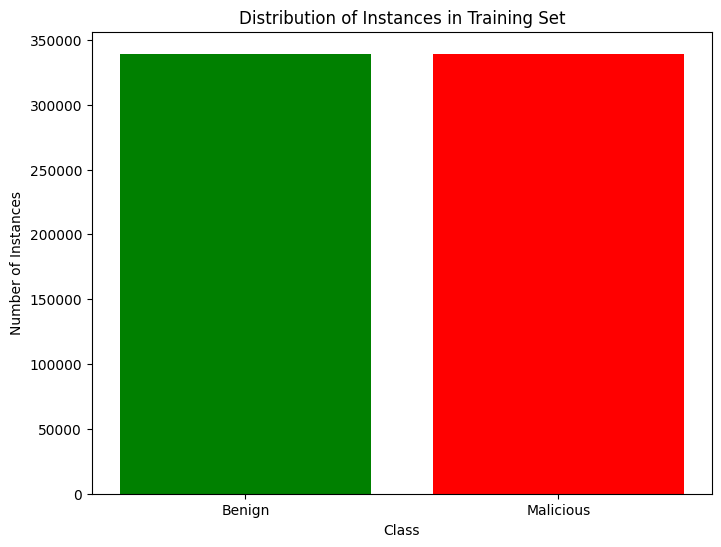

In [5]:
import matplotlib.pyplot as plt

# Count the number of benign and malicious instances in the training set
benign_count = y_train[y_train == 0].count()
malicious_count = y_train[y_train == 1].count()

# Print the counts
print(f"Number of Benign instances in the training set: {benign_count}")
print(f"Number of Malicious instances in the training set: {malicious_count}")

# Plot a bar chart
labels = ['Benign', 'Malicious']
counts = [benign_count, malicious_count]

plt.figure(figsize=(8, 6))
plt.bar(labels, counts, color=['green', 'red'])
plt.title('Distribution of Instances in Training Set')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.show()

In [4]:
from sklearn.model_selection import StratifiedKFold
# Cell 5: Build and Train Enhanced LSTM Model with Cross-Validation and Regularization
tf.keras.backend.clear_session()

def create_model():
    model = Sequential()
    model.add(Input(shape=(X_train_scaled.shape[1], 1)))  # Use Input layer
    model.add(LSTM(64, return_sequences=True, kernel_regularizer='l2'))  # Reduced units
    model.add(Dropout(0.5))  # Increased dropout rate
    model.add(LSTM(32, return_sequences=True, kernel_regularizer='l2'))
    model.add(Dropout(0.5))
    model.add(LSTM(16, kernel_regularizer='l2'))  # Reduced units
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5)
fold_no = 1

for train_index, val_index in skf.split(X_train_scaled, y_train):
    print(f"Training fold {fold_no}...")
    model = create_model()  # Create a new model instance for each fold
    
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    
    history = model.fit(
        X_train_fold, y_train_fold, 
        epochs=50, batch_size=64,  # Reduced epochs
        validation_data=(X_val_fold, y_val_fold), 
        callbacks=[early_stopping],
        verbose=1  # Set verbose to 1 to see training progress
    )
    
    # Indicate if early stopping was triggered
    if early_stopping.stopped_epoch > 0:
        print(f"Fold {fold_no} stopped early at epoch {early_stopping.stopped_epoch + 1} due to early stopping.")
    else:
        print(f"Fold {fold_no} completed for all epochs.")
    
    fold_no += 1

# Evaluate the final model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy}")

# Classification report
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred.round()))

# Cell 6: Save the Final Model in Native Keras Format
model.save('ddos_detection_lstm_model.keras')
print("Model saved to 'ddos_detection_lstm_model.keras'")

Training fold 1...
Epoch 1/50


2024-11-26 16:07:23.290442: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-11-26 16:07:23.290489: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: kudsit-dgxserver
2024-11-26 16:07:23.290496: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: kudsit-dgxserver
2024-11-26 16:07:23.290664: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 535.129.3
2024-11-26 16:07:23.290681: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 535.129.3
2024-11-26 16:07:23.290685: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 535.129.3


8479/8479 ━━━━━━━━━━━━━━━━━━━━ 142s 16ms/step - accuracy: 0.8593 - loss: 0.3769 - val_accuracy: 0.9650 - val_loss: 0.1109
Epoch 2/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 140s 16ms/step - accuracy: 0.9658 - loss: 0.1141 - val_accuracy: 0.9822 - val_loss: 0.0613
Epoch 3/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9797 - loss: 0.0706 - val_accuracy: 0.9797 - val_loss: 0.0643
Epoch 4/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9836 - loss: 0.0573 - val_accuracy: 0.9866 - val_loss: 0.0489
Epoch 5/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 144s 17ms/step - accuracy: 0.9866 - loss: 0.0484 - val_accuracy: 0.9900 - val_loss: 0.0352
Epoch 6/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9880 - loss: 0.0434 - val_accuracy: 0.9901 - val_loss: 0.0366
Epoch 7/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - accuracy: 0.9889 - loss: 0.0394 - val_accuracy: 0.9931 - val_loss: 0.0286
Epoch 8/50
8479/8479 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - accuracy: 0.9901 - lo

In [5]:
from sklearn.preprocessing import StandardScaler
# Cell 7: Robust Prediction Function
selected_features = [
    'Unnamed: 0', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Fwd Pkts/s', 'Hour', 'Flow IAT Max', 
    'Fwd Pkt Len Mean', 'Fwd Seg Size Avg', 'Fwd Pkt Len Max', 'Flow Duration', 'Flow IAT Mean', 
    'Init Fwd Win Byts', 'Fwd Pkt Len Std', 'Fwd IAT Max', 'Fwd IAT Std', 'Fwd IAT Tot', 
    'Fwd Header Len', 'Subflow Fwd Pkts', 'Fwd IAT Mean' ]


def predict_new_data(csv_file):
    # Load the saved model
    model = load_model('sucessful_new_model.keras')
    
    # Load and preprocess new data
    new_data = pd.read_csv(csv_file)
    new_data.columns = new_data.columns.str.strip()
    
    # Ensure the new data has the same features as the training data
    missing_cols = set(selected_features) - set(new_data.columns)
    for col in missing_cols:
        new_data[col] = 0  # Fill missing columns with zeros
    
    # Reorder columns to match the training data
    new_data = new_data[selected_features]
    
    # Scale the new data
    new_data_scaled = scaler.transform(new_data)
    
    # Make predictions
    predictions = model.predict(new_data_scaled)
    
    # Convert predictions to binary labels
    binary_predictions = (predictions > 0.5).astype(int)
    
    # Map binary predictions to labels
    label_mapping = {0: 'Normal', 1: 'Malicious'}
    labeled_predictions = [label_mapping[pred[0]] for pred in binary_predictions]
    
    # Count occurrences of each label
    normal_count = labeled_predictions.count('Normal')
    malicious_count = labeled_predictions.count('Malicious')
    
    return normal_count, malicious_count

# Example usage of the prediction function
new_csv_file_path = 'cicddos2019_dataset.csv'  # Replace with the actual path to your new CSV file
normal_count, malicious_count = predict_new_data(new_csv_file_path)

# Display the counts
print(f"Normal data count: {normal_count}")
print(f"DDoS data count: {malicious_count}")

13481/13481 ━━━━━━━━━━━━━━━━━━━━ 47s 3ms/step
Normal data count: 41585
DDoS data count: 389786


5300/5300 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step


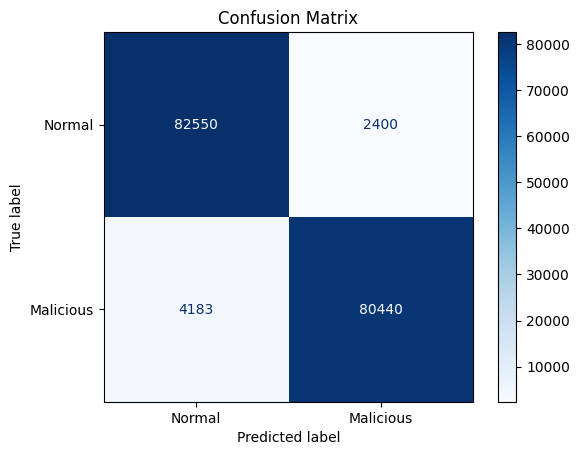

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
model = load_model('sucessful_new_model.keras')
# Assuming 'model' is your trained model and 'X_test', 'y_test' are your test data
# Generate predictions
# Assuming 'model' is your trained model and 'X_test', 'y_test' are your test data
# Generate predictions
y_pred = model.predict(X_test_scaled)
y_pred_classes = (y_pred > 0.5).astype(int)  # Convert probabilities to binary classes

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display confusion matrix with integer formatting
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Malicious'])
disp.plot(cmap=plt.cm.Blues, values_format='d')  # Use 'd' for integer formatting
plt.title('Confusion Matrix')
plt.show()